In [1]:
from sklearn import mixture
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print "Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds."
    else:
        print "Toc: start time not set"

# Helper functions:


In [3]:
def random_pdmat_gen(matrixSize):
    '''
    Function format: random_pdmat_gen(matrixSize)
    Returns a pos-def matrix of size matrixSize x matrixSize

    '''
    A = np.random.rand(matrixSize,matrixSize)
    return np.dot(A,A.T)
def random_posdefmat(Ns,matrixSize):
    '''
    Function format: random_posdefmat(Ns,matrixSize)
    Returns a Ns x matrixSize x matrixSize tensor consisting of Ns 
    pos-def matrices of size matrixSize x matrixSize

    '''
    X=np.zeros((Ns,matrixSize,matrixSize))
    for s in range(Ns):
        X[s,:,:]=random_pdmat_gen(matrixSize)
    return X
def random_pmf(Nc):
    p_unnorm=np.random.rand(Nc)
    return p_unnorm/p_unnorm.sum()
#############################################
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def plot_3D(X_samples,title=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x =X_samples[:,0]
    y =X_samples[:,1]
    z =X_samples[:,2]

    ax.scatter(x, y, z, c='r', marker='o')
    ax.set_title(title)


## Fix the $\mathbf{\pi}, \ \mathbf{\mu}, \ \mathbf{\Sigma}$ for the Gaussian Mixture model

In [4]:
Nc=4
Ndim=3

pi_vec=random_pmf(Nc)

mu_gen=np.array([[1, -1, 1], [-1,1,1],[1,1,1],[-1,-1,-1]])

Sig_gen=0.01*random_posdefmat(Nc,Ndim)

## Now, let's generate *$n_{samples}$* iid samples of $N_{dim}$-D Gaussians

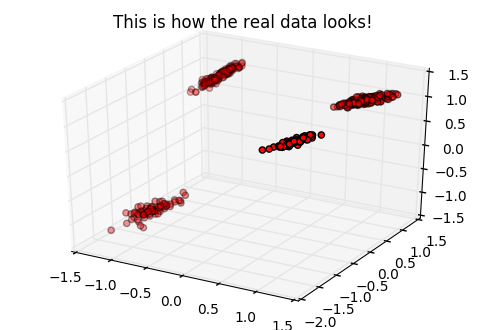

In [5]:
n_samples=500
# First generate the random cluster indices
cluster_indices=np.random.choice(Nc,n_samples, p=pi_vec,replace=True)
X_samples=np.zeros((n_samples,Ndim))
for s in range(n_samples):
    ind_s=cluster_indices[s]
    X_samples[s,:]=np.random.multivariate_normal(mu_gen[ind_s,:], Sig_gen[ind_s,:,:], 1)
plot_3D(X_samples,'This is how the real data looks!')


## Learn the mean and variances using Variational Inference.
Why not EM? http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#sphx-glr-auto-examples-mixture-plot-gmm-py

In [6]:
tic()
dpgmm = mixture.BayesianGaussianMixture(n_components=Nc,
                                        covariance_type='full').fit(X_samples)
toc()


Elapsed time is 0.0044949054718 seconds.


In [7]:
mu_est=dpgmm.means_
pi_est=dpgmm.weights_
Sig_est=dpgmm.covariances_

# If you want to numerically compare the estimated $\hat{\mathbf{\mu}}$ with $\mathbf{\mu}$, then first find the cluster-real to cluster-estimated mappings

In [8]:
i=0
map_ind=np.zeros(Nc,dtype=int)
for p in pi_vec:
    map_ind[i]=int(np.argmin(np.abs(pi_est-p)))
    i+=1
print('The mapping of the cluster indices are:')
print(map_ind)
print('Results: True means')
print(mu_gen)
print('Results: Predicted means')
mu_est[map_ind,:]

The mapping of the cluster indices are:
[0 2 2 0]
Results: True means
[[ 1 -1  1]
 [-1  1  1]
 [ 1  1  1]
 [-1 -1 -1]]
Results: Predicted means


array([[-0.97197933, -0.97608814, -0.97951927],
       [-1.01118723,  0.97738111,  0.98043684],
       [-1.01118723,  0.97738111,  0.98043684],
       [-0.97197933, -0.97608814, -0.97951927]])

# Visualization of data generated by the true GMM and the estimated GMM

### First, we generate the synthetic GMMs

In [9]:
X_synthetic=np.zeros((n_samples,Ndim))
cluster_indices=np.random.choice(Nc,n_samples, p=pi_est,replace=True)
for s in range(n_samples):
    ind_s=cluster_indices[s]
    X_synthetic[s,:]=np.random.multivariate_normal(mu_est[ind_s,:], Sig_est[ind_s,:,:], 1)


## *Now, we visualize the two..*

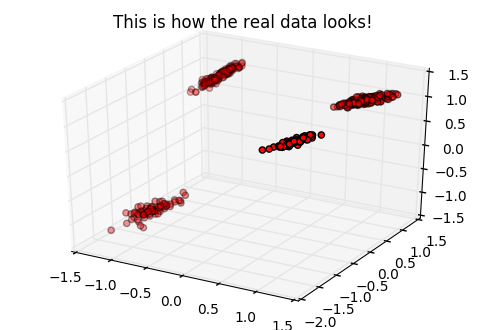

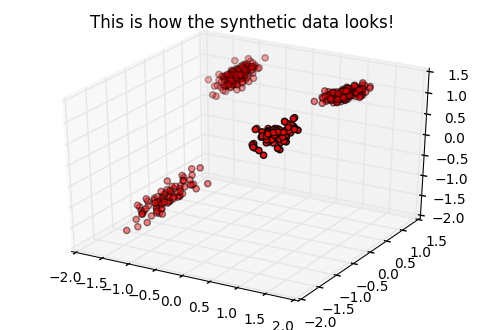

In [10]:
plt.figure()
plot_3D(X_samples,'This is how the real data looks!')
plot_3D(X_synthetic,'This is how the synthetic data looks!')

# This part pertains to client model adaptation:

# There are $n_e$ enrollement samples and $n_m$ mixtures


In [11]:
from scipy.stats import multivariate_normal as MVN
Y_enroll=X_synthetic
n_e=Y_enroll.shape[0]
n_m=Nc
p_mat=np.zeros((n_e,n_m))
for q in range(n_e):
    y_q=Y_enroll[q,:]   
    for i in range(n_m):
        p_mat[q,i]=pi_est[i]*MVN.pdf(y_q, mean=mu_est[i,:], cov=Sig_est[i,:,:])

# Normalize to get cluster-wise aposterior probabilities
norm_den=p_mat.sum(axis=1)
Pr_i_q=p_mat / norm_den.reshape(n_e,1) # What is the probability that sample 'q' belongs to the 'i'th cluster

```
Note that multivariate_normal.pdf(y, mean=mu, cov=Sig) does just this:

Num=np.exp(-0.5*np.dot(np.dot((y-mu).T,np.linalg.inv(Sig)),(y-mu)))
Den=np.sqrt((2*np.pi)**len(y)*np.linalg.det(Sig))
Num/Den

```

In [12]:
r_hyp=4
n_i_vec=Pr_i_q.sum(axis=0)
alpha_i_vec=n_i_vec/(n_i_vec+r_hyp)

In [13]:
# E_i_Yenroll: This is the per-mixture mean given the Enrollment dataset
mu_update=np.zeros((n_m,Ndim))
E_i=np.zeros((n_m,Ndim))
for i in range(n_m):
    e_i=np.zeros(Ndim)
    for q in range(n_e):
        y_q=Y_enroll[q,:]
        e_i+=Pr_i_q[q,i]*y_q
    n_i=n_i_vec[i]
    E_i[i,:]=e_i/n_i
    mu_i=mu_est[i,:]
    alpha_i=alpha_i_vec[i]
    mu_update[i,:]=alpha_i*E_i[i,:]+(1-alpha_i)*mu_i
print('After getting some more data and updated the mean, the updated mean looks like:')
mu_update

After getting some more data and updated the mean, the updated mean looks like:


array([[-1.0221241 , -1.01750554, -1.02511125],
       [ 0.97034799,  0.98203862,  0.99102863],
       [-1.02406345,  0.97627971,  0.97948681],
       [ 0.95584403, -0.9957872 ,  0.97666013]])

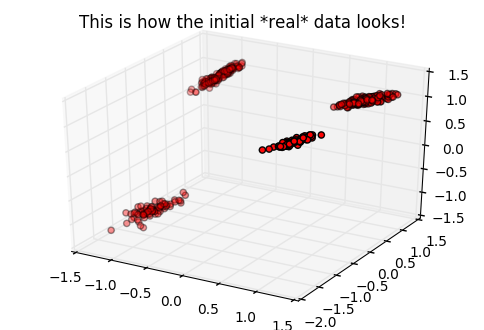

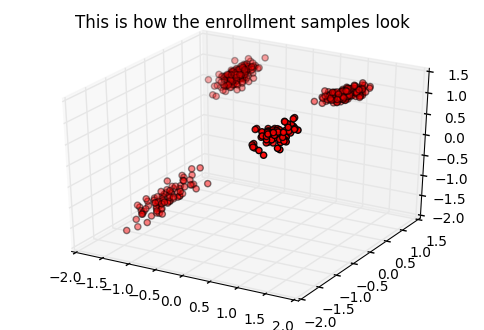

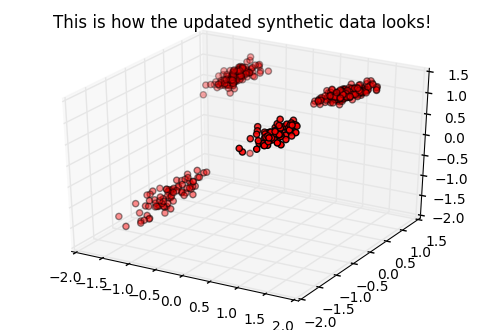

In [14]:
X_synthetic_new=np.zeros((n_samples,Ndim))
cluster_indices=np.random.choice(Nc,n_samples, p=pi_est,replace=True)
for s in range(n_samples):
    ind_s=cluster_indices[s]
    X_synthetic_new[s,:]=np.random.multivariate_normal(mu_update[ind_s,:], Sig_est[ind_s,:,:], 1)
plt.figure()
plot_3D(X_samples,'This is how the initial *real* data looks!')
plot_3D(X_synthetic,'This is how the enrollment samples look')
plot_3D(X_synthetic_new,'This is how the updated synthetic data looks!')

# Here, we will convert some of the code into functions

In [97]:
def learn_UBM(X_train, M, cov_type='tied',train_algo='DP'):
    if train_algo=='DP':
        model_UBM = mixture.BayesianGaussianMixture(n_components=M,
                                        covariance_type=cov_type).fit(X_train)
    else:
        model_UBM = mixture.GaussianMixture(n_components=M,
                                        covariance_type=cov_type).fit(X_train)
    return model_UBM

def enroll_user(X_enroll,model_UBM):
    N=X_test.shape[0]
    score_user=model_user.score(X_test)
    score_UBM=model_UBM.score(X_test)
    mean_diff_score=(model_user.score(X_test)-model_UBM.score(X_test))
    return mean_diff_score, score_user, score_UBM

def score_user_data(X_test,model_user,model_UBM):
    N=X_test.shape[0]
    score_user=model_user.score(X_test)
    score_UBM=model_UBM.score(X_test)
    mean_diff_score=(model_user.score(X_test)-model_UBM.score(X_test))
    return mean_diff_score, score_user, score_UBM


In [105]:
model_UBM=learn_UBM(X_samples,4,train_algo='EM')
model_user=learn_UBM(X_synthetic,4,train_algo='EM')
score_user_data(X_synthetic_new,model_user,model_UBM)

(5.4763497601879028, 0.46224267825559329, -5.0141070819323099)

In [109]:
print model_user.bic(X_synthetic_new)
model_UBM.bic(X_samples)

-331.735908189


-2506.7312811636539

In [167]:
from scipy.stats import multivariate_normal as MVN
from copy import deepcopy

def enroll_user(Y_enroll, model_UBM,r_hyp=4):

    pi_est=model_UBM.weights_
    mu_est=model_UBM.means_
    Sig_est=model_UBM.covariances_
    n_m=model_UBM.n_components
    n_e=Y_enroll.shape[0]

    p_mat=np.zeros((n_e,n_m))
    for q in range(n_e):
        y_q=Y_enroll[q,:]   
        for i in range(n_m):
#             p_mat[q,i]=pi_est[i]*MVN.pdf(y_q, mean=mu_est[i,:], cov=Sig_est[i,:,:])
            p_mat[q,i]=pi_est[i]*MVN.pdf(y_q, mean=mu_est[i,:], cov=Sig_est)

    # Normalize to get cluster-wise aposterior probabilities
    norm_den=p_mat.sum(axis=1)
    Pr_i_q=p_mat / norm_den.reshape(n_e,1) # What is the probability that sample 'q' belongs to the 'i'th cluster
    r_hyp=4
    n_i_vec=Pr_i_q.sum(axis=0)
    alpha_i_vec=n_i_vec/(n_i_vec+r_hyp)
    # E_i_Yenroll: This is the per-mixture mean given the Enrollment dataset
    mu_update=np.zeros((n_m,Ndim))
    E_i=np.zeros((n_m,Ndim))
    for i in range(n_m):
        e_i=np.zeros(Ndim)
        for q in range(n_e):
            y_q=Y_enroll[q,:]
            e_i+=Pr_i_q[q,i]*y_q
        n_i=n_i_vec[i]
        E_i[i,:]=e_i/n_i
        mu_i=mu_est[i,:]
        alpha_i=alpha_i_vec[i]
        mu_update[i,:]=alpha_i*E_i[i,:]+(1-alpha_i)*mu_i
        model_user=deepcopy(model_UBM)
        model_user.means_=mu_update
    return model_user

In [163]:
model_UBM=learn_UBM(X_samples,4)
model_user=enroll_user(X_synthetic, model_UBM,r_hyp=4)
model_user.covariances_

array([[ 0.02856561,  0.01114101,  0.01459242],
       [ 0.01114101,  0.02587501,  0.01513444],
       [ 0.01459242,  0.01513444,  0.01850829]])

In [168]:
model_UBM.score(X_synthetic)

0.59561722924962257